# Ranking metrics from first principles: Average Precision

In [1]:
from fractions import Fraction
import itertools
import math
import typing as t

import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Rectangle
import numpy as np
import pandas as pd
from sklearn.metrics import average_precision_score as ap

In [2]:
assert ap([True, False, True], [1, 0.5, 1]) == 1.0

### Toy data

In [3]:
items = ('🌭', '🍔', '🌮', '🍕', '🍣')
users = ('🙂', '🤓')

ground_truth = {
    '🙂': {
        '🌭': True,
        '🍔': True,
        '🌮': True,
        '🍕': False,
        '🍣': False,
    },
    '🤓': {
        '🍕': True,
        '🍣': True,
        '🌮': False,
        '🌭': False,
        '🍔': False,
    },
}

ranker_results = {
    1: {
        '🙂': ['🌭', '🍔', '🌮', '🍕', '🍣'],
        '🤓': ['🍕', '🍣', '🌮', '🌭', '🍔'],
    },
    2: {
        '🙂': ['🌮', '🌭', '🍔', '🍣', '🍕'],
        '🤓': ['🍣', '🍕', '🌭', '🌮', '🍔'],
    },
    3: {
        '🙂': ['🍣', '🍕', '🌮', '🌭', '🍔'],
        '🤓': ['🌮', '🍔', '🌭', '🍣', '🍕'],
    },
    4: {
        '🙂': ['🌭', '🍣', '🍔', '🍕', '🌮'],
        '🤓': ['🍕', '🌮', '🍣', '🌭', '🍔'],
    },
}

In [4]:
def user_ap(
    user: str,
    ranking: t.Sequence[str],
) -> float:
    y_pred = list(range(len(ranking), 0, -1))
    y_true = [
        ground_truth[user][item]
        for item in ranking
    ]
    return ap(y_true, y_pred)

In [5]:
user_ap(user='🙂', ranking=ranker_results[1]['🙂'])

1.0

In [6]:
pd.DataFrame(
    dict(
        ranker=ranker,
        user=user,
        ap=user_ap(user=user, ranking=ranking)
    )
    for ranker, res in ranker_results.items()
    for user, ranking in res.items()
).groupby(['ranker', 'user']).ap.mean().unstack().round(2)

user,🙂,🤓
ranker,,
1,1.00,1.00
2,1.00,1.00
3,0.48,0.32
4,0.76,0.83


In [7]:
def swap(
    ranking: t.Sequence[str],
    i: int,
    j: int,
) -> t.List[str]:
    tmp = ranking[::]
    tmp[i], tmp[j] = tmp[j], tmp[i]
    return tmp

In [8]:
ranker4 = ranker_results[4]
user_ap(
    user='🙂',
    ranking=swap(ranker4['🙂'], i=1, j=2),
)

0.8666666666666667

In [9]:
user_ap(
    user='🤓',
    ranking=swap(ranker4['🤓'], i=1, j=2),
)

1.0

In [10]:
SEED = 0
N_ITER = 10_000

np.random.seed(SEED)

df_user_ap_random_rankings = pd.DataFrame(
    dict(
        user=user,
        ap=user_ap(
            user=user,
            ranking=np.random.choice(
                items,
                replace=False,
                size=len(items),
            )
        ),
    )
    for user in users
    for _ in range(N_ITER)
)
df_user_ap_random_rankings.groupby('user').ap.describe().round(2)

,count,mean,std,min,25%,50%,75%,max
user,,,,,,,,
🙂,10000.0,0.73,0.16,0.48,0.59,0.76,0.87,1.0
🤓,10000.0,0.59,0.21,0.32,0.42,0.50,0.75,1.0


### PR curves

In [11]:
class PrecisionRecallCurve:
    SCORES = [0.9, 0.7, 0.5, 0.3, 0.1]
    
    @staticmethod
    def _precision(df: pd.DataFrame, score: float, op: str) -> float:
        cond = getattr(df.score, op)(score)
        return df[cond].ground_truth.mean()
    
    @staticmethod
    def _recall(df: pd.DataFrame, score: float, op: str) -> float:
        cond = getattr(df.score, op)(score)
        p = df.ground_truth.sum()
        return df[cond].ground_truth.sum() / p
    
    @classmethod
    def _get_user_ranker_df(
        cls,
        user: str,
        ranker_nbr: int,
    ) -> pd.DataFrame:
        res_user = ranker_results[ranker_nbr][user]
        gt_user = [ground_truth[user][item] for item in res_user]
        return pd.DataFrame(dict(
            ground_truth=gt_user,
            score=cls.SCORES,
        ))
    
    @classmethod
    def _plot(
        cls,
        user: str,
        ranker_nbr: int,
        fn,
        name: str,
    ) -> None:
        scores = [0] + sorted(cls.SCORES) + [1]
        df = cls._get_user_ranker_df(
            user=user,
            ranker_nbr=ranker_nbr,
        )
        y = [
            fn(df=df, score=s, op=op)
            for s in scores
            for op in ("ge", "gt")
        ]
        x = [s for s in scores for _ in range(2)]
        pd.DataFrame(dict(
            Threshold=x,
            y=y,
        )).set_index('Threshold').y.plot()
        plt.ylabel(name)
        plt.ylim([-0.1, 1.1])
        plt.xlim([-0.1, 1.1])

    @classmethod
    def plot_recall_for_user(
        cls,
        user: str,
        ranker_nbr: int,
    ) -> None:
        cls._plot(
            user=user,
            ranker_nbr=ranker_nbr,
            fn=cls._recall,
            name="Recall",
        )
        
    @classmethod
    def plot_precision_for_user(
        cls,
        user: str,
        ranker_nbr: int,
    ) -> None:
        cls._plot(
            user=user,
            ranker_nbr=ranker_nbr,
            fn=cls._precision,
            name="Precision",
        )
        
    @classmethod
    def pr_points(
        cls,
        user: str,
        ranker_nbr: int,
    ) -> pd.DataFrame:
        ranked = ranker_results[ranker_nbr][user]
        df = pd.DataFrame(
            dict(
                rank=idx + 1,
                item=item,
                is_pos=ground_truth[user][item],
            )
            for idx, item in enumerate(ranked)
        )
        is_pos_cum = df.is_pos.cumsum()
        pos_cnt = is_pos_cum.iloc[-1]
        df = df.assign(
            precision=is_pos_cum / df['rank'],
            recall=is_pos_cum / pos_cnt,
        )
        df = df.assign(
            recall_diff=df.recall - df.recall.shift().fillna(0)
        )
        return df.assign(
            ap=(df.precision * df.recall_diff).cumsum(),
        )
    
    @classmethod
    def plot_pr_points(
        cls,
        user: str,
        ranker_nbr: int,
        show_ap: bool = True,
        show_auc: bool = True,
    ) -> None:
        df = cls.pr_points(
            user=user,
            ranker_nbr=ranker_nbr,
        )
        df_pos = df[df.is_pos]
        df_neg = df[~df.is_pos]
        ap_ = ap(
            df.is_pos,
            list(range(len(df))[::-1]),
        )
        args = dict(
            x='recall',
            y='precision',
            marker='+',
            s=60,
            c='g',
            title=f'AP = {ap_:.2f}' if show_ap else None,
        )
        ax = df_pos.plot.scatter(**args)
        args_mod = dict(
            marker='_',
            c='r',
            ax=ax,
        )
        df_neg.plot.scatter(**{**args, **args_mod})

        if show_auc:
            beg = 0
            for _, row in df_pos.iterrows():
                rect = Rectangle(
                    (beg, 0),
                    row.recall_diff,
                    row.precision,
                    linewidth=.5,
                    edgecolor='c',
                    facecolor='c',
                    alpha=.1,
                )
                beg = row.recall
                ax.add_patch(rect)

        lims = (-0.1, 1.1)
        plt.xlim(*lims)
        plt.ylim(*lims)

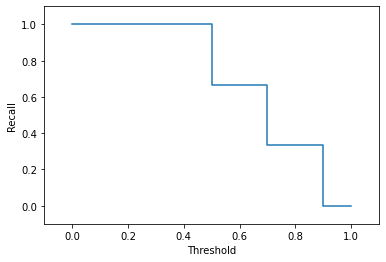

In [12]:
PrecisionRecallCurve.plot_recall_for_user(user='🙂', ranker_nbr=2)

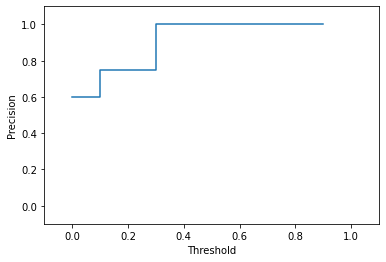

In [13]:
PrecisionRecallCurve.plot_precision_for_user(user='🙂', ranker_nbr=2)

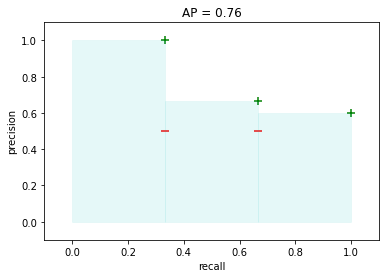

In [14]:
PrecisionRecallCurve.plot_pr_points(
    user='🙂',
    ranker_nbr=4,
)

### AP calculation

In [15]:
def ap_simple(
    ranked: t.Sequence[bool]
) -> float:
    pos_cnt = 0
    precision_sum = 0
    for idx, r in enumerate(ranked):
        if r:
            pos_cnt += 1
            precision_sum += pos_cnt / (idx + 1)
    if pos_cnt == 0:
        return float('nan')
    return precision_sum / pos_cnt

In [16]:
assert ap_simple([True]) == 1
assert ap_simple([True] * 10) == 1
assert ap_simple([True, False]) == 1
assert ap_simple([False, True]) == 1 / 2
assert ap_simple([False, False, True]) == 1/3

assert ap_simple([True, False, True, True, False]) == (1 + 2/3 + 3/4) / 3
assert ap_simple([False, True, False, False, True]) == (1/2 + 2/5) / 2
assert ap_simple([True] * 5) == 1
assert np.isnan(ap_simple([False] * 5))
assert ap_simple([False, True, False, False, False]) == 1/2

### Worst-case AP

In [17]:
def ap_worst_case(N: int, P: int) -> float:
    assert 0 < P <= N
    return sum(
        i / (N - P + i)
        for i in range(1, P + 1)
    ) / P

In [18]:
assert round(ap_worst_case(N=5, P=3), 2) == 0.48
assert ap_worst_case(N=5, P=2) == 0.325

#### plots

In [19]:
def ap_worst_simple(n: int, p: int) -> float:
    assert 0 < p <= n
    return sum(
        i / (n - p + i)
        for i in range(1, p + 1)
    ) / p


def ap_worst(rankings: t.Sequence[str]) -> float:
    return ap_worst_case(
        N=len(rankings), P=sum(rankings),
    )


def ap_worst_by_p_smallest_n(p: Fraction) -> float:
    return ap_worst_n_p(n=p.denominator, p=float(p))


def ap_worst_n_p(n, p):
    pp = n * p
    if pp == int(pp):
        return dict(
            N=n,
            p=p,
            ap=ap_worst_simple(n=n, p=int(pp)),
        )

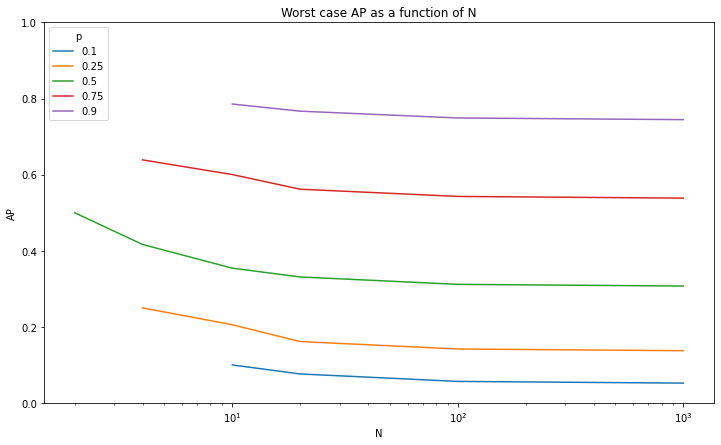

In [20]:
ps = (0.1, .25, .5, .75, .9)
ns = (2, 4, 5, 10, 20, int(1e2), int(1e3))

res = (
    ap_worst_n_p(n, p)
    for n in ns
    for p in ps
)
_ = pd.DataFrame(
    x
    for x in res
    if x is not None
).groupby(['N', 'p']).ap.mean().unstack().interpolate().plot(
    logx=True,
    figsize=(12, 7),
    ylabel='AP',
    ylim=[0, 1],
)
_ = plt.title('Worst case AP as a function of N')

In [21]:
ps = (
    Fraction(1, 100),
    Fraction(1, 10),
    Fraction(1, 4),
    Fraction(1, 2),
    Fraction(3, 4),
    Fraction(9, 10),
    Fraction(99, 100),
    Fraction(999, 1_000),
)

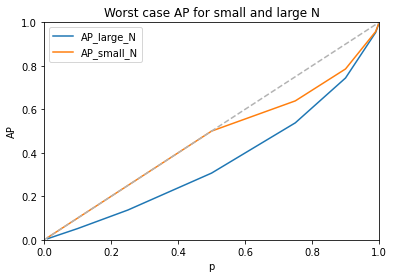

In [22]:
fig = pd.DataFrame(
    dict(
        p=float(p),
        AP_large_N=ap_worst_n_p(n=1_000_000, p=float(p))['ap'],
        AP_small_N=ap_worst_by_p_smallest_n(p=p)['ap'],
    )
    for p in ps
).set_index('p').plot(ylim=[0, 1], xlim=[0, 1], ylabel='AP')
_ = fig.plot([0, 1], [0, 1], transform=fig.transAxes, ls='--', c=".7")
_ = plt.title('Worst case AP for small and large N')

### Expected AP

In [23]:
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [24]:
def expected_ap_naive(N: int, P: int) -> float:
    return sum(
        ap_simple(r)
        for r in itertools.permutations([True] * P + [False] * (N - P))
    ) / math.factorial(N)


def expected_ap_p1(N: int) -> float:
    return sum(
        1 / i
        for i in range(1, N + 1)
    ) / N


def expected_ap_naive2(N: int, P: int) -> int:
    N_choose_P = math.comb(N, P)
    return (1 / N_choose_P) * sum(
        ap_simple(
            [x in set(rs) for x in range(1, N + 1)]
        )
        for rs in itertools.combinations(range(1, N + 1), P)
    )

def expected_ap_simulate(N: int, P: int, iters: int = 1_000) -> float:
    r = [True] * P + [False] * (N - P)
    return sum(
        ap_simple(np.random.permutation(r))
        for _ in range(iters)
    ) / iters

#### plots

In [25]:
def simulate(items: t.Sequence[bool]) -> pd.Series:
    np.random.seed(SEED)
    return pd.Series(
        ap_simple(
            ranked=np.random.choice(
                items, replace=False, size=len(items))
        )
        for _ in range(N_ITER)
    ).describe()


def simulate_np(N: int, p: float) -> float:
    P = N * float(p)
    if int(P) == P:
        P = int(P)
        return simulate(
            items=[True] * P + [False] * (N - P)
        )['mean']


def plot_range_p_ap(a, b):
    fig = df[[a, b]].plot(color=['r', 'g'])
    plt.fill_between(
        df.index,
        [0] * len(df),
        df[a],
        alpha=.1,
        color='grey',
    )
    plt.fill_between(
        df.index,
        df[a],
        df[b],
        alpha=.1,
        color='red',
    )
    plt.fill_between(
        df.index,
        df[b],
        [1] * len(df),
        alpha=.1,
        color='green',
    )
    fig.plot([0, 1], [0, 1], transform=fig.transAxes, ls='--', c=".7")
    plt.xlim([0, 1])
    plt.ylim([0, 1])

In [26]:
df_exp = pd.DataFrame(
    dict(
        p=p,
        N=n,
        ap=simulate_np(N=n, p=p),
    )
    for p in ps
    for n in ns
)

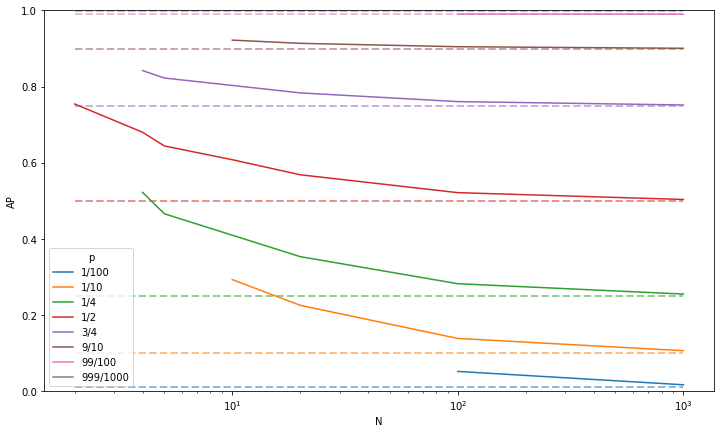

In [27]:
fig = df_exp.groupby(['N', 'p']).ap.mean().unstack().interpolate().plot(
    logx=True,
    figsize=(12, 7),
    ylabel='AP',
    ylim=[0, 1],
)
pd.DataFrame(
    dict(
        N=n,
        p=p,
        ap=p,
    )
    for n in [ns[0], ns[-1]]
    for p in ps
)
for c, p in zip(COLORS, ps):
    fig.hlines(y=float(p), xmin=ns[0], xmax=ns[-1], linewidth=2, color=c, ls='--', alpha=.5)

In [28]:
df = pd.DataFrame(
    dict(
        p=float(p),
        worst_case_large_N=ap_worst_n_p(n=1_000_000, p=float(p))['ap'],
        worst_case_small_N=ap_worst_by_p_smallest_n(p=p)['ap'],
        expected_small_N=simulate_np(
            N=p.denominator,
            p=float(p),
        ),
        expected_large_N=simulate_np(
            N=1_000,
            p=float(p),
        ),
    )
    for p in ps
).set_index('p')

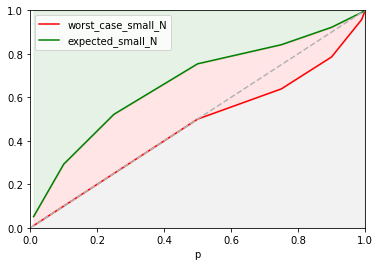

In [29]:
plot_range_p_ap(a='worst_case_small_N', b='expected_small_N')

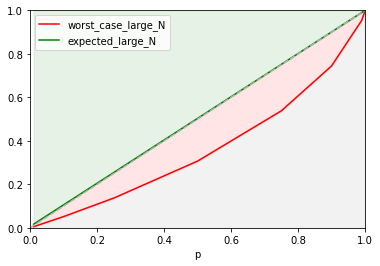

In [30]:
plot_range_p_ap(a='worst_case_large_N', b='expected_large_N')